## 1. Data Cleaning & Setup

In [1]:
import pandas as pd

df = pd.read_csv('../SAMEED/HPA/HPA_metadata.csv')
df.replace({"TRUE": True, "FALSE": False}, inplace=True)
df.head()

,Idx,file,ID,cell_type,"actin filaments,focal adhesion sites",aggresome,"centrosome,centriolar satellite",cytosol,endoplasmic reticulum,golgi apparatus,...,mitotic spindle,no staining,nuclear bodies,nuclear membrane,nuclear speckles,nucleoli,nucleoli fibrillar center,nucleoplasm,"plasma membrane,cell junctions","vesicles,peroxisomes,endosomes,lysosomes,lipid droplets,cytoplasmic bodies"
0,0,/scratch3/SAMEED/HPA/HPA_DINO_CELLS/dataset/10...,10005_921_B9_1,A-431,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,/scratch3/SAMEED/HPA/HPA_DINO_CELLS/dataset/10...,10005_921_B9_1,A-431,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2,/scratch3/SAMEED/HPA/HPA_DINO_CELLS/dataset/10...,10005_921_B9_1,A-431,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,3,/scratch3/SAMEED/HPA/HPA_DINO_CELLS/dataset/10...,10005_921_B9_1,A-431,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,4,/scratch3/SAMEED/HPA/HPA_DINO_CELLS/dataset/10...,10005_921_B9_1,A-431,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


#### Check Missing Values

In [2]:
print(df.isnull().sum())

Idx                                                                           0
file                                                                          0
ID                                                                            0
cell_type                                                                     0
actin filaments,focal adhesion sites                                          0
aggresome                                                                     0
centrosome,centriolar satellite                                               0
cytosol                                                                       0
endoplasmic reticulum                                                         0
golgi apparatus                                                               0
intermediate filaments                                                        0
microtubules                                                                  0
mitochondria                            

 **No missing values** were found in any column, ensuring dataset completeness and readiness for analysis.

### Define Label Columns

In [3]:
label_cols = df.columns[4:] 
print (label_cols)

Index(['actin filaments,focal adhesion sites', 'aggresome',
       'centrosome,centriolar satellite', 'cytosol', 'endoplasmic reticulum',
       'golgi apparatus', 'intermediate filaments', 'microtubules',
       'mitochondria', 'mitotic spindle', 'no staining', 'nuclear bodies',
       'nuclear membrane', 'nuclear speckles', 'nucleoli',
       'nucleoli fibrillar center', 'nucleoplasm',
       'plasma membrane,cell junctions',
       'vesicles,peroxisomes,endosomes,lysosomes,lipid droplets,cytoplasmic bodies'],
      dtype='object')


In [4]:
len(df), len(label_cols)

(629694, 19)

In [5]:
df[label_cols].sum()

actin filaments,focal adhesion sites                                           14448
aggresome                                                                       3400
centrosome,centriolar satellite                                                27761
cytosol                                                                       189362
endoplasmic reticulum                                                          17958
golgi apparatus                                                                43299
intermediate filaments                                                         11023
microtubules                                                                   13381
mitochondria                                                                   50894
mitotic spindle                                                                 1650
no staining                                                                    26807
nuclear bodies                                                   

#### Obervation:

A total of **19 binary columns** were identified in the dataset, each representing a possible **subcellular localization** of a protein. These labels indicate whether a specific cellular structure is present (`True`) or not (`False`) in a given image.

These columns include:

- **Individual subcellular structures**, such as:
  - `cytosol`
  - `nucleoplasm`
  - `nucleoli`
  - `nuclear speckles`
  - `mitochondria`, `golgi apparatus`, `microtubules`, etc.

- **Grouped or composite labels**, which combine multiple biologically related structures into a single column. For example:
  - `"vesicles,peroxisomes,endosomes,lysosomes,lipid droplets,cytoplasmic bodies"`: This column is marked `True` if *any* of these vesicle-related organelles are present.
  - `"actin filaments,focal adhesion sites"`: This indicates the presence of cytoskeletal components or adhesion-related structures.

These grouped labels are likely the result of either:
- **Co-staining during imaging** where multiple structures are labeled with a shared marker, or
- **Annotation strategies** used by the dataset creators (e.g., Human Protein Atlas), where biologically similar compartments are collapsed into broader categories.

These labels form the basis of a **multi-label classification** problem, where each image can be annotated with multiple (possibly overlapping) structures.


In [6]:
print("Total images:", len(df))
print("Total labels:", len(label_cols))
print("Unique cell types:", df['cell_type'].nunique())

Total images: 629694
Total labels: 19
Unique cell types: 29


### Interpretation

- The dataset is **well-structured and clean** with no null entries, simplifying preprocessing and modeling.
- The large number of samples (629K+) supports robust machine learning, though careful handling of **class imbalance** will be crucial.
- Multiple **cell types** enable biological diversity analysis and possibly **domain-specific model performance evaluation**.
- Composite label names suggest co-staining or weakly-supervised annotations. These should be interpreted cautiously during downstream modeling.

## 2. Class Distributions & Frequencies

### Label Frequency Plot

<Axes: title={'center': 'Label Frequency'}>

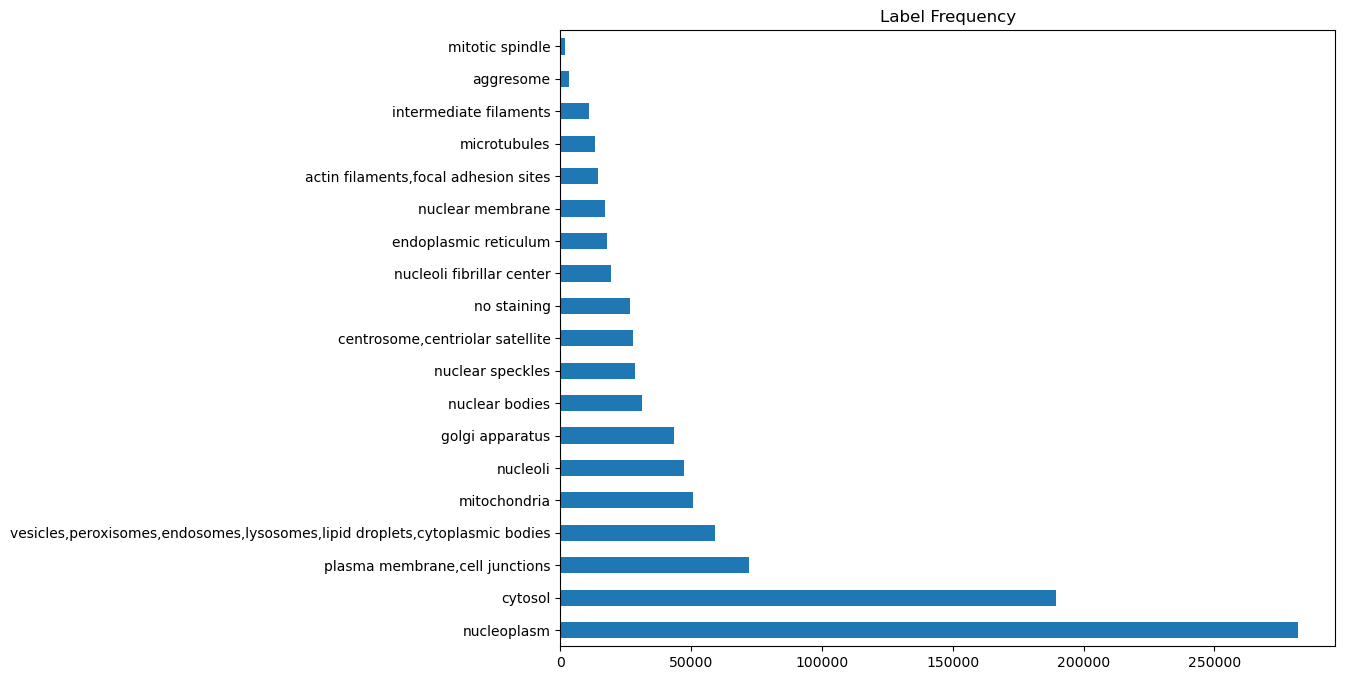

In [7]:
df[label_cols].sum().sort_values(ascending=False).plot(
    kind='barh', figsize=(10, 8), title='Label Frequency')


#### Observations:
- The most frequent labels are:
  - `nucleoplasm` (~270K samples)
  - `cytosol` (~190K samples)
  - `plasma membrane,cell junctions`
- The least frequent include:
  - `mitotic spindle`
  - `aggresome`
  - `intermediate filaments`

#### Interpretation:
- There is **significant class imbalance**, with certain compartments (like `nucleoplasm`) being 50x more common than rare ones (e.g., `mitotic spindle`).
- This imbalance will need to be addressed in downstream modeling using techniques like class weighting, focal loss, or data augmentation.


### Labels per Image Histogram

<Axes: >

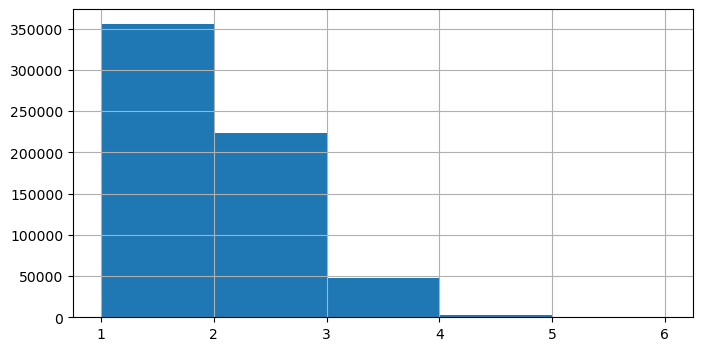

In [8]:
df['num_labels'] = df[label_cols].sum(axis=1)
df['num_labels'].hist(bins=range(1, df['num_labels'].max()+2), figsize=(8, 4))

#### Observations:
- Most images are annotated with **1 to 2 labels**
- A smaller subset has **3 or more labels**

#### Interpretation:
- The dataset is a **multi-label classification problem**, but not heavily multi-labeled — making it relatively simpler than datasets with dense label combinations.
- Images with more than 3 structures may represent biologically complex or highly stained samples.


### Label Percentage Distribution

In [9]:
label_percent = (df[label_cols].sum() / len(df) * 100).sort_values(ascending=False)
imbalance_df = pd.DataFrame({
    "Label": label_percent.index,
    "Percentage of Images": label_percent.values
})
print(imbalance_df)

                                                Label  Percentage of Images
0                                         nucleoplasm             44.799696
1                                             cytosol             30.072067
2                      plasma membrane,cell junctions             11.478432
3   vesicles,peroxisomes,endosomes,lysosomes,lipid...              9.389481
4                                        mitochondria              8.082338
5                                            nucleoli              7.498563
6                                     golgi apparatus              6.876197
7                                      nuclear bodies              4.969715
8                                    nuclear speckles              4.540777
9                     centrosome,centriolar satellite              4.408649
10                                        no staining              4.257147
11                          nucleoli fibrillar center              3.091025
12          

### Observations:
Among all subcellular structure labels, **nucleoplasm** is the most frequently occurring, present in approximately **44.8%** of all images. This is followed by **cytosol**, appearing in around **30.1%** of the samples. In contrast, rare structures such as **aggresome** and **mitotic spindle** are present in only **0.54%** and **0.26%** of the dataset, respectively, highlighting the pronounced class imbalance within the label distribution.

### Interpretation:
The dataset exhibits significant label imbalance, which is typical in biological imaging datasets.
Model performance may be biased toward dominant labels unless strategies like class reweighting, oversampling, or focal loss are applied.

### Label Cardinality & Label Density

In [10]:
cardinality = df['num_labels'].mean()
density = cardinality / len(label_cols)
print(f"Label Cardinality: {cardinality:.2f}")
print(f"Label Density: {density:.4f}")

Label Cardinality: 1.52
Label Density: 0.0800


**Label Cardinality** represents the **average number of labels per image**.

- **Cardinality:** `1.52`

#### Interpretation:
- On average, each image is annotated with approximately **1.5 subcellular structures**, confirming the **multi-label nature** of the task.

**Label Density** is calculated as:
> Label Cardinality ÷ Total Number of Labels

- **Density:** `0.0800`

#### Interpretation:
- Only ~8% of the possible labels are active per image, suggesting the dataset is **sparse** in label activation.
- This supports the need for **multi-label-aware** models that handle sparse positive classes effectively (e.g., sigmoid activation with binary cross-entropy).

### Cell Type Distribution

<Axes: title={'center': 'Cell Type Distribution'}, xlabel='cell_type'>

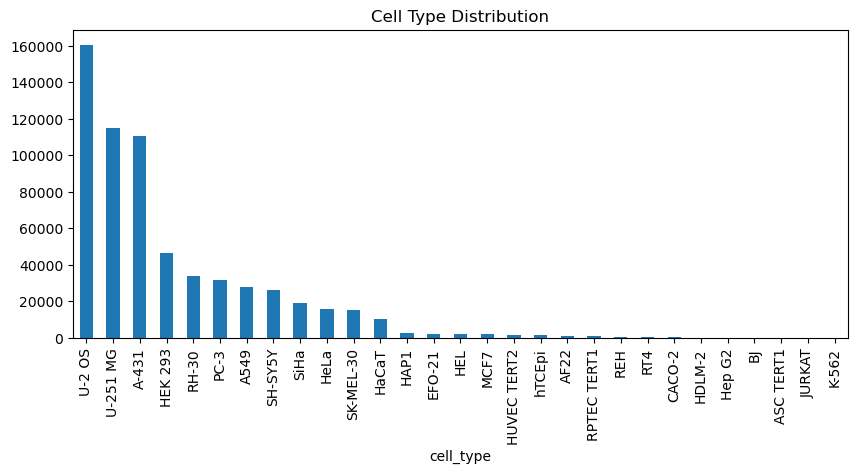

In [11]:
df['cell_type'].value_counts().plot(kind='bar', figsize=(10, 4), title='Cell Type Distribution')

#### Observations:
- **U-2 OS**, **U-251 MG**, and **A-431** are the most represented cell types.
- Several cell types have very few samples (e.g., **BJ**, **K562**, **JURKAT**).

#### Interpretation:
- Just like with subcellular structures, **cell type imbalance** is present.
- Some models (e.g., stratified training or cell-type-specific analysis) might be needed to ensure generalization across cell types.
- Alternatively, under-represented cell types can be excluded or grouped depending on the study’s focus.


## 3. Image Metadata & Visualization

### Check Image Shapes & Sizes

In [12]:
from PIL import Image
import os

image_shapes = []
for path in df['file']:
    try:
        img = Image.open(path)
        image_shapes.append(img.size)
    except:
        pass

dims_df = pd.DataFrame(image_shapes, columns=['width', 'height'])
dims_df.describe()

,width,height
count,629694.0,629694.0
mean,512.0,512.0
std,0.0,0.0
min,512.0,512.0
25%,512.0,512.0
50%,512.0,512.0
75%,512.0,512.0
max,512.0,512.0


####  Observations:
- **Image shape:** 100% of images are `512 × 512` pixels
- **No outliers** were found in width or height
- Mean, min, max, and quartiles are all exactly 512 for both dimensions

#### Interpretation:
- The dataset is **uniform in resolution**, which simplifies preprocessing (no resizing or cropping required).
- No corrupted or mis-sized images detected — indicating a clean image dataset.

### Visualize Sample Images

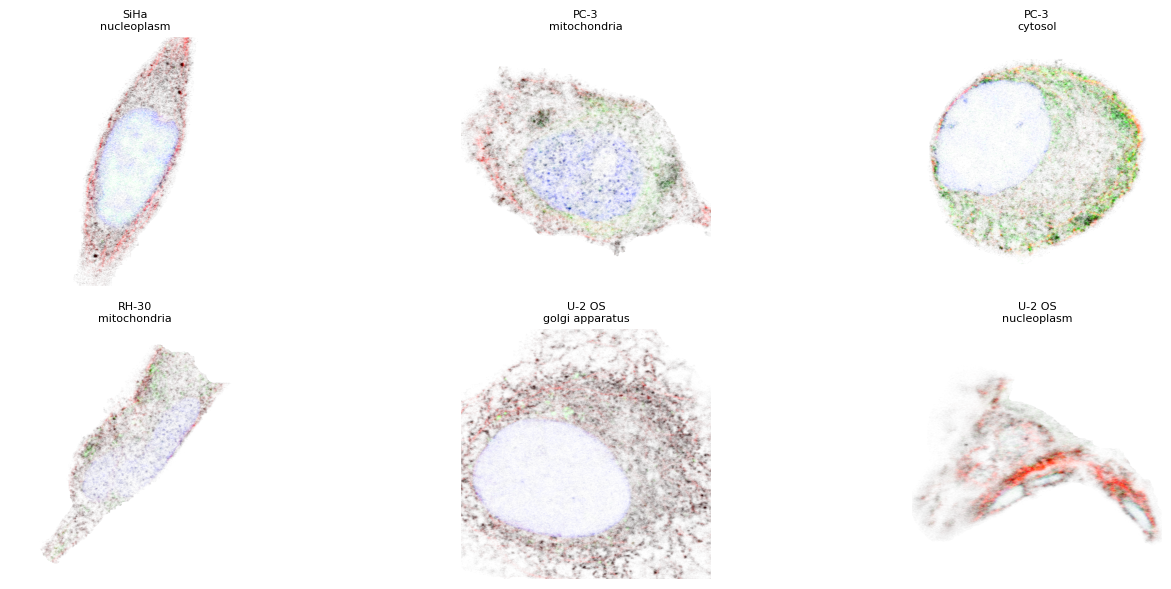

In [13]:
import matplotlib.pyplot as plt
import random

def show_random_images(df, label_cols, n=6):
    samples = df.sample(n)
    plt.figure(figsize=(15, 6))
    for i, (_, row) in enumerate(samples.iterrows()):
        try:
            img = Image.open(row['file'])
            plt.subplot(2, 3, i + 1)
            plt.imshow(img)
            plt.axis('off')
            active_labels = [col for col in label_cols if row[col]]
            plt.title(f"{row['cell_type']}\n" + '\n'.join(active_labels), fontsize=8)
        except Exception as e:
            print(f"Could not open {row['file']}: {e}")
    plt.tight_layout()
    plt.show()

show_random_images(df, label_cols)

## 4. Co-occurrence Analysis

### Label Correlation Heatmap

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5]),
 [Text(0.5, 0, 'actin filaments,focal adhesion sites'),
  Text(1.5, 0, 'aggresome'),
  Text(2.5, 0, 'centrosome,centriolar satellite'),
  Text(3.5, 0, 'cytosol'),
  Text(4.5, 0, 'endoplasmic reticulum'),
  Text(5.5, 0, 'golgi apparatus'),
  Text(6.5, 0, 'intermediate filaments'),
  Text(7.5, 0, 'microtubules'),
  Text(8.5, 0, 'mitochondria'),
  Text(9.5, 0, 'mitotic spindle'),
  Text(10.5, 0, 'no staining'),
  Text(11.5, 0, 'nuclear bodies'),
  Text(12.5, 0, 'nuclear membrane'),
  Text(13.5, 0, 'nuclear speckles'),
  Text(14.5, 0, 'nucleoli'),
  Text(15.5, 0, 'nucleoli fibrillar center'),
  Text(16.5, 0, 'nucleoplasm'),
  Text(17.5, 0, 'plasma membrane,cell junctions'),
  Text(18.5, 0, 'vesicles,peroxisomes,endosomes,lysosomes,lipid droplets,cytoplasmic bodies')])

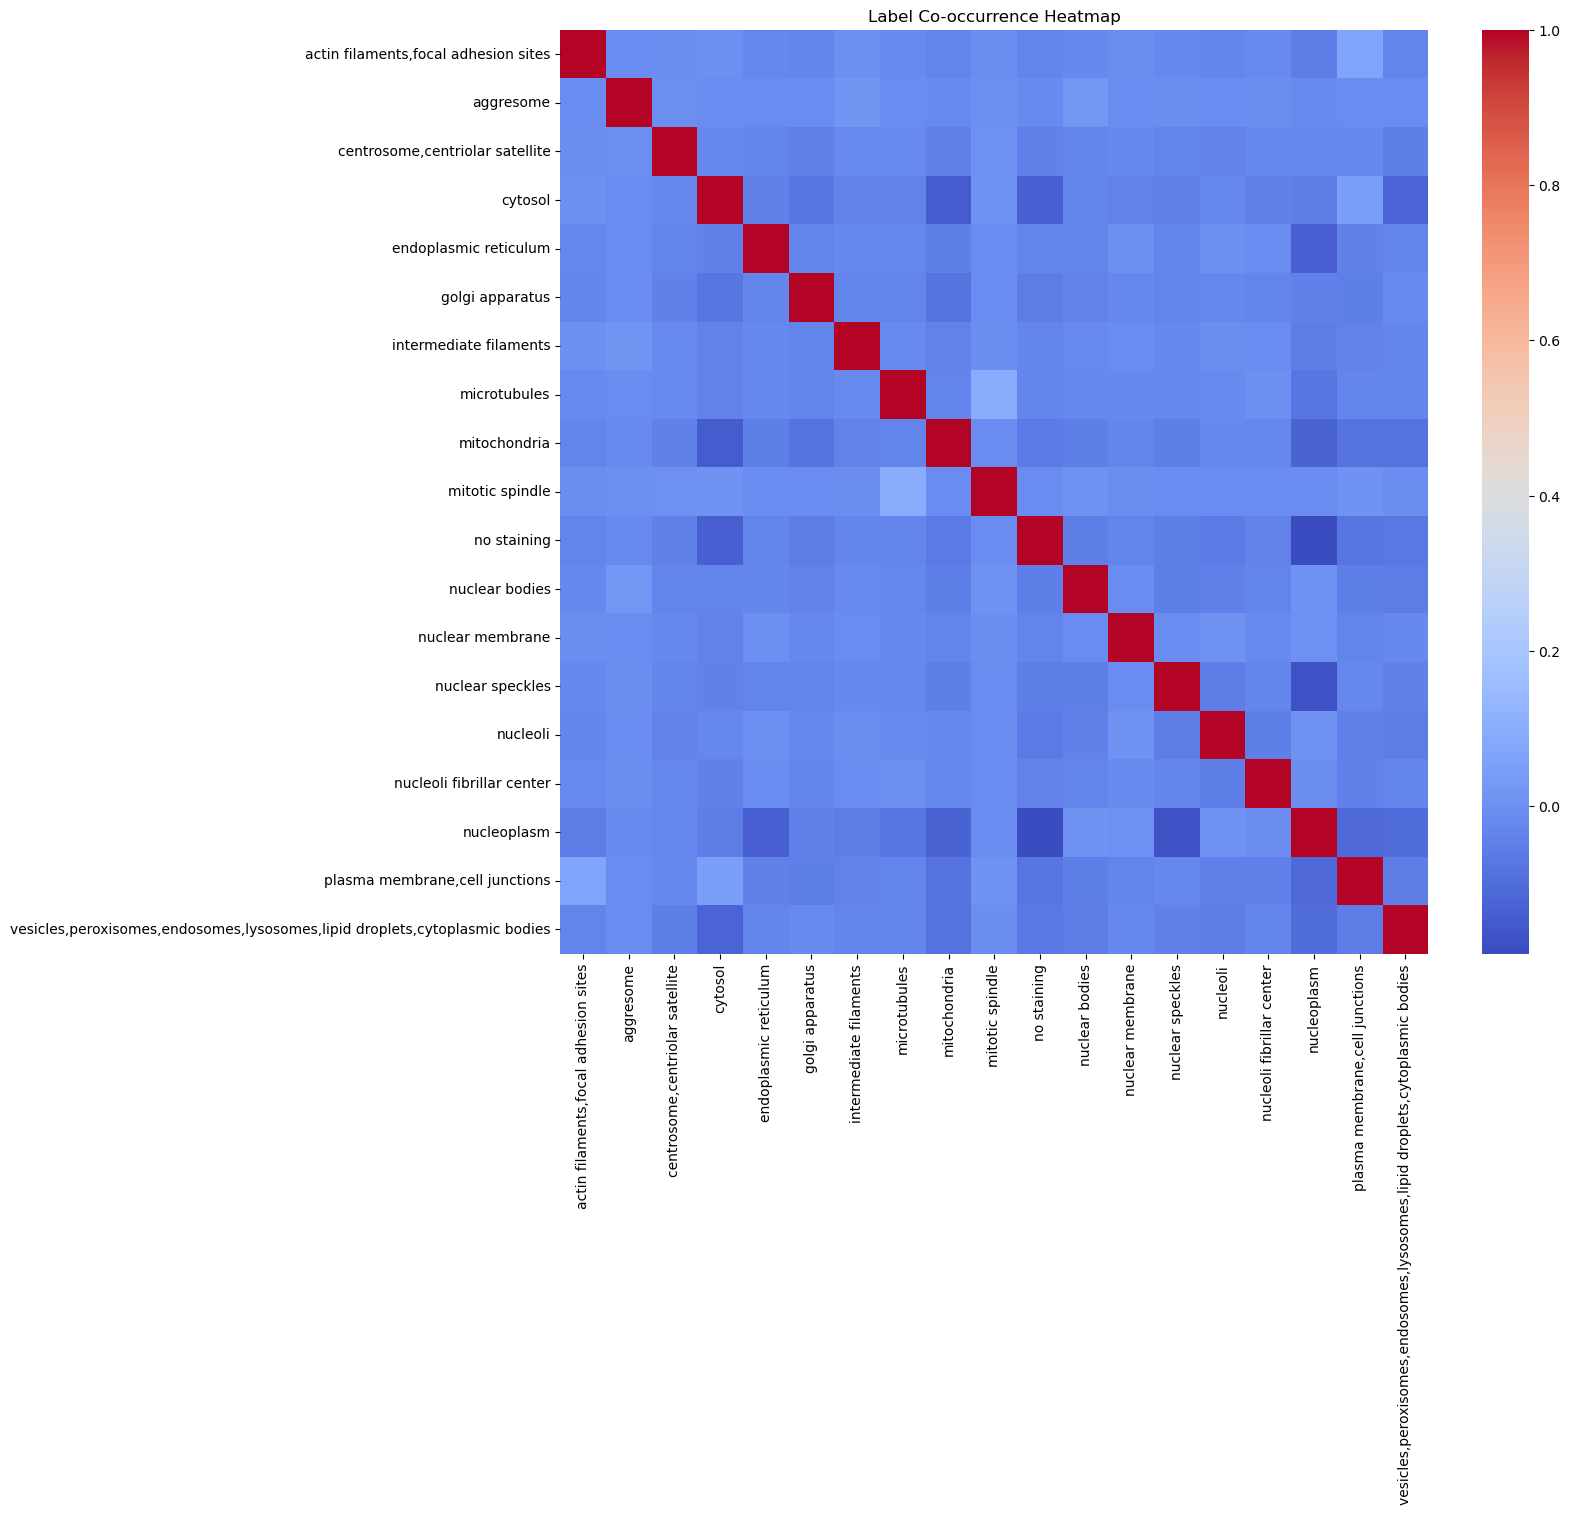

In [14]:
import seaborn as sns

corr = df[label_cols].corr()
plt.figure(figsize=(14, 12))
sns.heatmap(corr, cmap='coolwarm', xticklabels=True, yticklabels=True)
plt.title("Label Co-occurrence Heatmap")
plt.xticks(rotation=90)

####  Observations:
- Strong positive correlations (bright regions) are visible between:
  - `nucleoli` ↔ `nucleoplasm`
  - `nuclear speckles` ↔ `nucleoplasm`
  - `cytosol` ↔ `vesicles,peroxisomes,...`
- Labels like `aggresome` or `mitotic spindle` show **very little correlation** with others

####  Interpretation:
- Certain structures tend to **frequently co-appear**, possibly due to biological proximity or co-staining (e.g., nuclear compartments).
- These relationships can help in **multi-label model optimization**, such as structured loss functions or label dependencies in graph-based models.

### Cell Type × Label Heatmap

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5]),
 [Text(0, 0.5, 'A-431'),
  Text(0, 1.5, 'A549'),
  Text(0, 2.5, 'AF22'),
  Text(0, 3.5, 'ASC TERT1'),
  Text(0, 4.5, 'BJ'),
  Text(0, 5.5, 'CACO-2'),
  Text(0, 6.5, 'EFO-21'),
  Text(0, 7.5, 'HAP1'),
  Text(0, 8.5, 'HDLM-2'),
  Text(0, 9.5, 'HEK 293'),
  Text(0, 10.5, 'HEL'),
  Text(0, 11.5, 'HUVEC TERT2'),
  Text(0, 12.5, 'HaCaT'),
  Text(0, 13.5, 'HeLa'),
  Text(0, 14.5, 'Hep G2'),
  Text(0, 15.5, 'JURKAT'),
  Text(0, 16.5, 'K-562'),
  Text(0, 17.5, 'MCF7'),
  Text(0, 18.5, 'PC-3'),
  Text(0, 19.5, 'REH'),
  Text(0, 20.5, 'RH-30'),
  Text(0, 21.5, 'RPTEC TERT1'),
  Text(0, 22.5, 'RT4'),
  Text(0, 23.5, 'SH-SY5Y'),
  Text(0, 24.5, 'SK-MEL-30'),
  Text(0, 25.5, 'SiHa'),
  Text(0, 26.5, 'U-2 OS'),
  Text(0, 27.5, 'U-251 MG'),
  Text(0, 28.5, 'hTCEpi')])

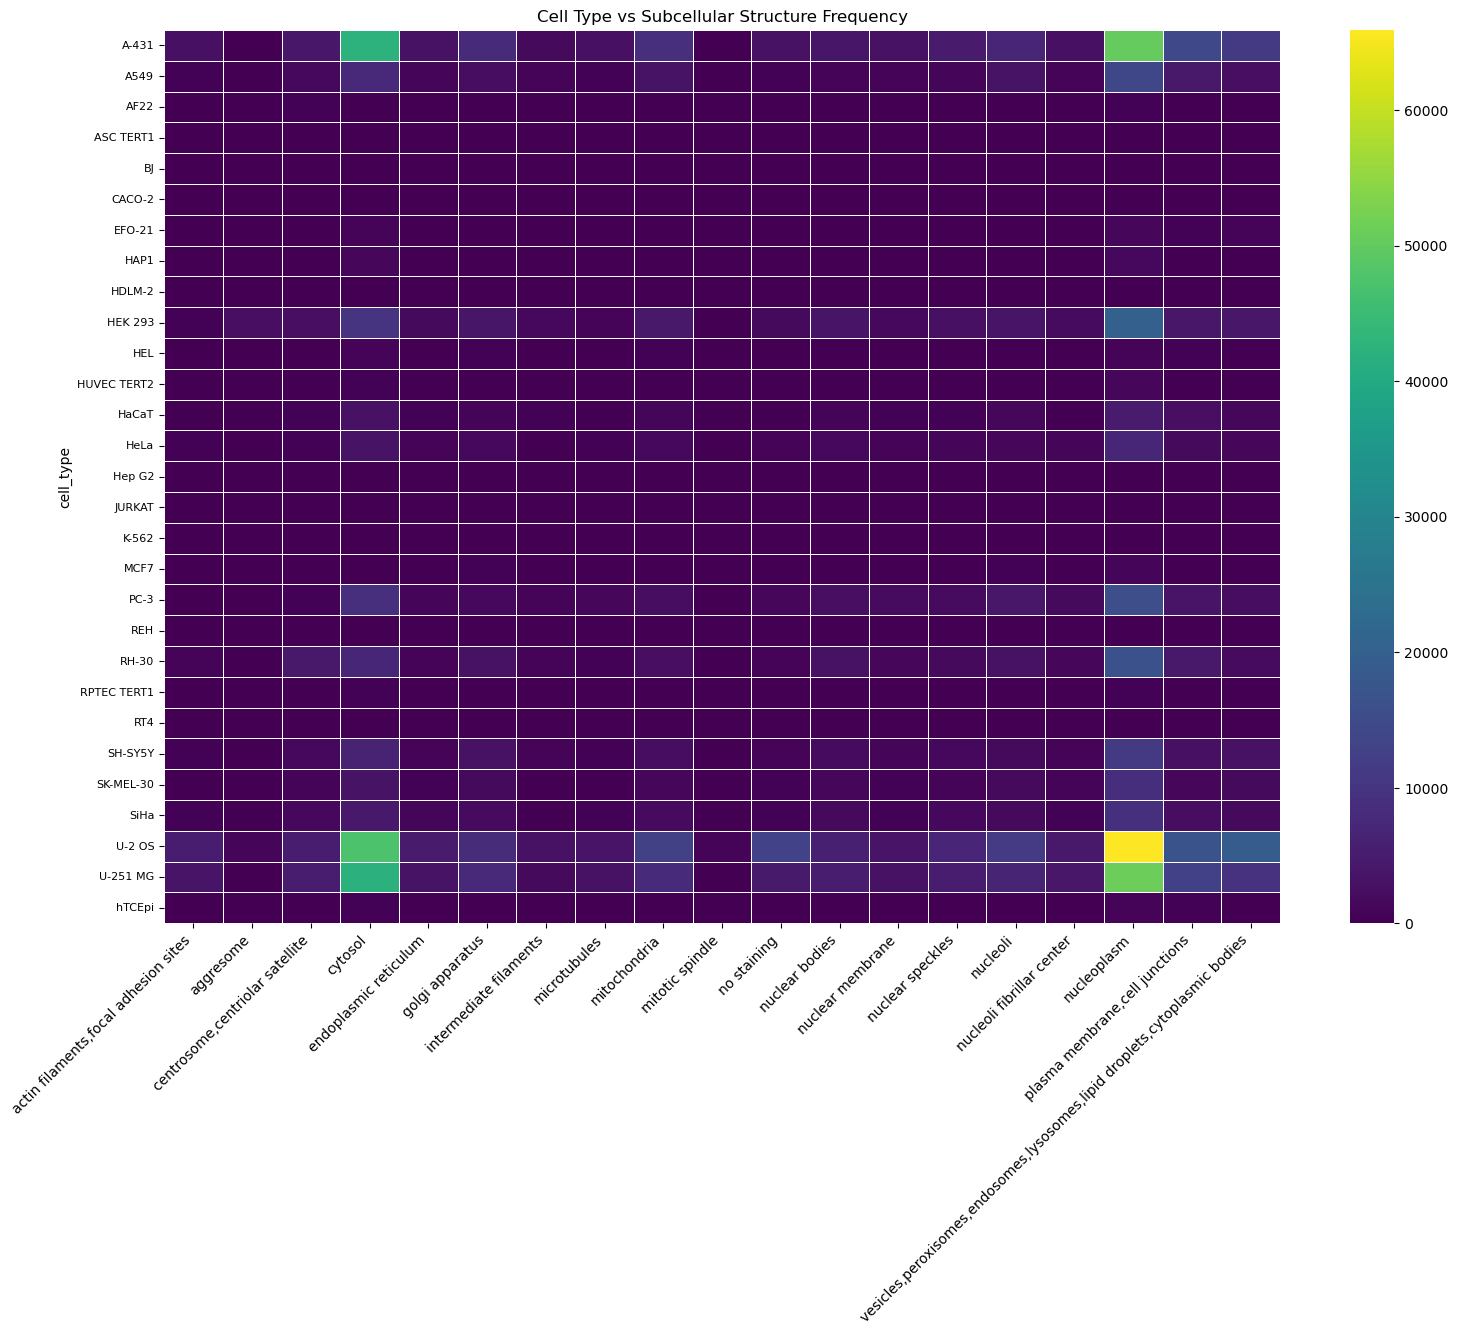

In [15]:
grouped = df.groupby('cell_type')[label_cols].sum()
plt.figure(figsize=(18, max(8, len(grouped) * 0.4)))
sns.heatmap(grouped, cmap='viridis', linewidths=0.5)
plt.title("Cell Type vs Subcellular Structure Frequency")
plt.xticks(rotation=45, ha='right')
plt.yticks(fontsize=8)

In [16]:
grouped = df.groupby('cell_type')[label_cols].sum()
grouped.head(10)

,"actin filaments,focal adhesion sites",aggresome,"centrosome,centriolar satellite",cytosol,endoplasmic reticulum,golgi apparatus,intermediate filaments,microtubules,mitochondria,mitotic spindle,no staining,nuclear bodies,nuclear membrane,nuclear speckles,nucleoli,nucleoli fibrillar center,nucleoplasm,"plasma membrane,cell junctions","vesicles,peroxisomes,endosomes,lysosomes,lipid droplets,cytoplasmic bodies"
cell_type,,,,,,,,,,,,,,,,,,,
A-431,2599,38,3933,42279,3033,7849,1675,2765,8894,119,3060,3694,2965,4889,6939,2619,50234,14221,11043
A549,487,19,1310,7682,853,2288,524,354,3295,122,410,632,532,875,3269,575,13970,4368,2350
AF22,8,2,307,139,0,56,59,19,167,20,0,31,6,31,96,45,478,39,4
ASC TERT1,0,0,0,6,0,8,0,0,2,0,0,0,0,0,0,0,9,0,0
BJ,0,0,0,0,0,0,3,0,0,0,0,2,0,0,0,5,12,4,0
CACO-2,7,7,3,32,11,3,37,27,40,0,0,7,10,3,0,8,83,74,0
EFO-21,0,0,66,633,88,139,0,16,149,36,33,125,35,52,119,77,1279,437,517
HAP1,34,0,0,1147,0,109,0,11,123,109,67,108,43,53,64,31,1344,208,198
HDLM-2,0,0,3,24,0,3,2,0,58,0,0,0,3,7,5,0,36,37,0


#### Observations:
- **A-431**, **U-2 OS**, and **U-251 MG** show strong expression of multiple subcellular structures.
- Cell types like `BJ`, `K562`, and `JURKAT` show relatively fewer label activations.
- Some structures (e.g., `nucleoplasm`, `cytosol`) appear widely across many cell types.

#### Interpretation:
- This reveals **biological heterogeneity**: different cell types express or highlight different cellular compartments more prominently.
- This can guide stratified model evaluation and may suggest **cell-type–aware augmentation or normalization** strategies.


### Label Cardinality & Density

## 5. Check for Missing / Corrupt Images

In [17]:
df['exists'] = df['file'].apply(os.path.exists)
print("Missing images:", (~df['exists']).sum())

Missing images: 0


#### Observation:
- **Missing images:** 0
- All **629,694 file paths** referenced in the dataset are valid and point to existing `.png` image files.

#### Interpretation:
- The dataset is fully intact with **no missing or broken image links**, which ensures smooth batch loading, visualization, and model training without any interruptions or need for error handling logic.

## 6. Export Label Matrix

In [18]:
X = df['file'].values
Y = df[label_cols].astype(int).values

##  Overall EDA Takeaways

This exploratory data analysis (EDA) provided a comprehensive understanding of the medical image dataset containing cell-level annotations across 19 subcellular structures.

###  1. Dataset Quality & Structure
- The dataset consists of **629,694 images**, each sized **512×512 pixels**.
- All image paths are valid and accessible; **no missing or corrupt files** were found.
- Metadata is complete, with **no null values** across any fields.

### 2. Label Characteristics
- A total of **19 subcellular labels** were identified, including both **individual structures** (e.g., `cytosol`, `nucleoli`) and **grouped compartments** (e.g., `vesicles,peroxisomes,...`).
- The task is **multi-label** in nature:  
  - **Label cardinality:** 1.52 (avg. labels per image)  
  - **Label density:** 0.0800 (avg. label activity per image)

###  3. Class Imbalance & Label Sparsity
- Labels are **highly imbalanced**:
  - `nucleoplasm` appears in ~45% of samples, while `mitotic spindle` is present in just ~0.26%.
- The label imbalance and sparsity call for techniques like **class weighting**, **focal loss**, or **data resampling** to ensure fair model performance.

###  4. Multi-label Co-occurrence
- Strong correlations observed between related nuclear structures (e.g., `nucleoplasm` ↔ `nucleoli`, `nuclear speckles`).
- Weak or no co-occurrence among rare compartments.
- These patterns suggest potential for **multi-label dependency modeling** (e.g., with graph-based or attention-based architectures).

###  5. Cell Type Diversity
- The dataset contains **29 unique cell types**, with significant skew (e.g., `U-2 OS`, `A-431` heavily represented).
- Label distribution varies significantly across cell types, highlighting the **biological heterogeneity** in the dataset.

This EDA confirms the dataset is **high-quality**, **biologically diverse**, and well-prepared for multi-label classification. However, it also reveals challenges such as:
- Severe **class imbalance**
- Sparse label presence
- **Cell-type-specific label patterns**

<Figure size 1000x600 with 0 Axes>

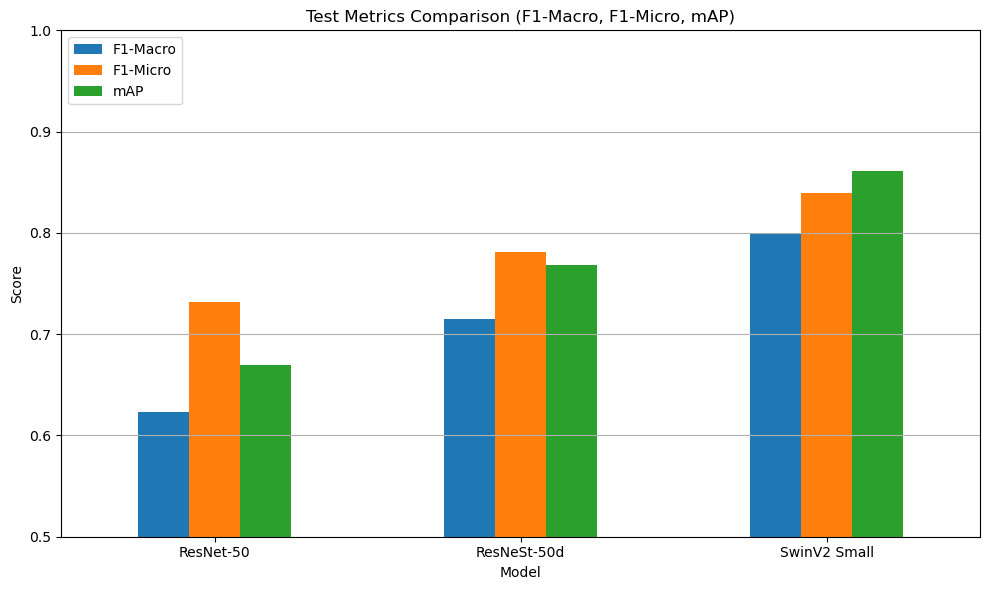

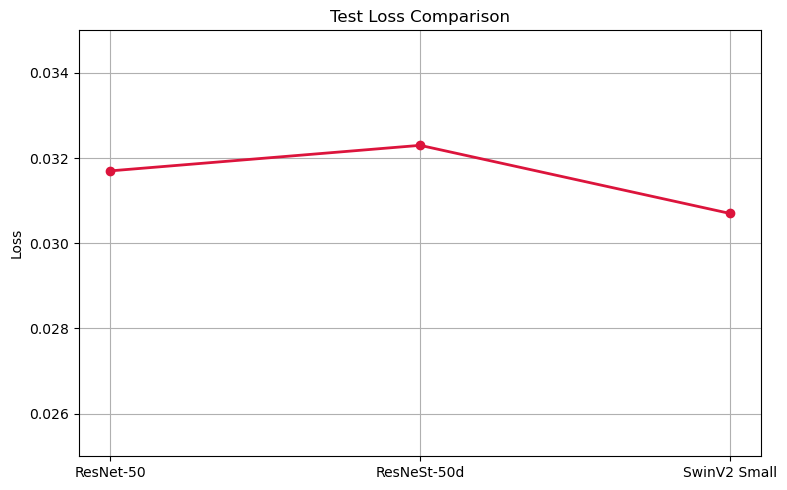

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Create DataFrame from your test results
data = {
    'Model': ['ResNet-50', 'ResNeSt-50d', 'SwinV2 Small'],
    'Loss': [0.0317, 0.0323, 0.0307],
    'F1-Macro': [0.623, 0.715, 0.800],
    'F1-Micro': [0.732, 0.781, 0.839],
    'mAP': [0.670, 0.768, 0.861]
}

df = pd.DataFrame(data)

# Set model as index for plotting convenience
df.set_index('Model', inplace=True)

# Plot 1: Comparison of F1-Macro, F1-Micro, mAP
plt.figure(figsize=(10, 6))
df[['F1-Macro', 'F1-Micro', 'mAP']].plot(kind='bar', figsize=(10, 6))
plt.title('Test Metrics Comparison (F1-Macro, F1-Micro, mAP)')
plt.ylabel('Score')
plt.ylim(0.5, 1.0)
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Plot 2: Loss Comparison
plt.figure(figsize=(8, 5))
plt.plot(df.index, df['Loss'], marker='o', color='crimson', linewidth=2)
plt.title('Test Loss Comparison')
plt.ylabel('Loss')
plt.ylim(0.025, 0.035)
plt.grid(True)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


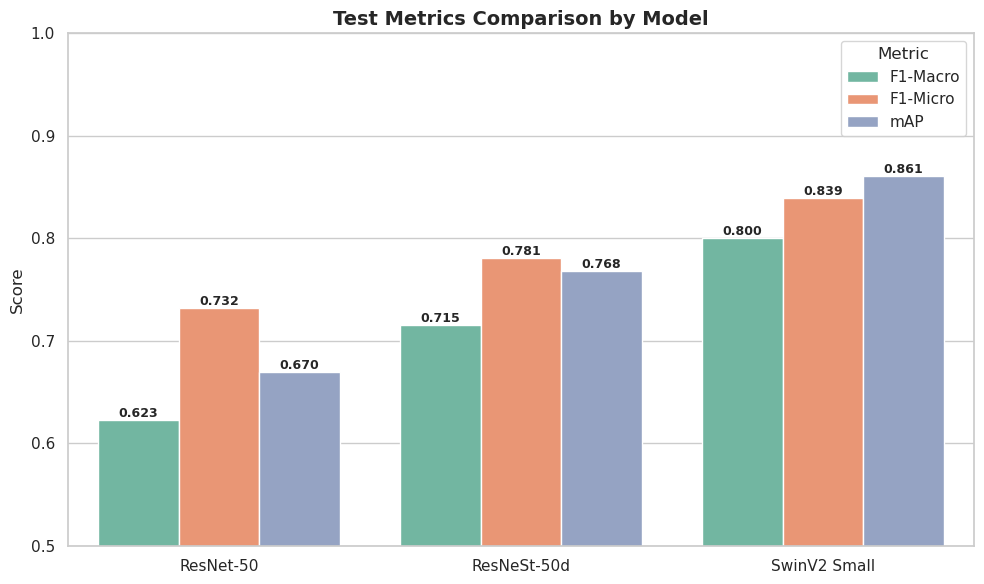

/tmp/ipykernel_28343/1487739791.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x=df.index, y=df['Loss'].values, palette='coolwarm')


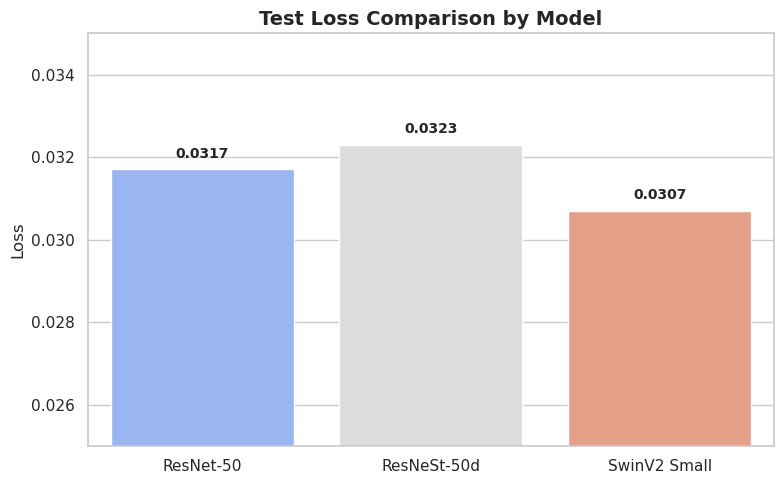

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Use a clean white grid style
sns.set(style="whitegrid")

# --- Data ---
data = {
    'Model': ['ResNet-50', 'ResNeSt-50d', 'SwinV2 Small'],
    'Loss': [0.0317, 0.0323, 0.0307],
    'F1-Macro': [0.623, 0.715, 0.800],
    'F1-Micro': [0.732, 0.781, 0.839],
    'mAP': [0.670, 0.768, 0.861]
}

df = pd.DataFrame(data)
df.set_index('Model', inplace=True)

# --- Plot 1: Test Metrics Comparison ---
metrics_df = df[['F1-Macro', 'F1-Micro', 'mAP']].reset_index().melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
ax1 = sns.barplot(data=metrics_df, x='Model', y='Score', hue='Metric', palette='Set2')

# Add value labels on each bar
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{height:.3f}', 
                 (p.get_x() + p.get_width() / 2., height), 
                 ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.title('Test Metrics Comparison by Model', fontsize=14, weight='bold')
plt.ylabel('Score')
plt.ylim(0.5, 1.0)
plt.xlabel('')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

# --- Plot 2: Test Loss Comparison ---
plt.figure(figsize=(8, 5))
ax2 = sns.barplot(x=df.index, y=df['Loss'].values, palette='coolwarm')

# Add value labels on each bar
for i, val in enumerate(df['Loss'].values):
    ax2.text(i, val + 0.0002, f"{val:.4f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('Test Loss Comparison by Model', fontsize=14, weight='bold')
plt.ylabel('Loss')
plt.ylim(0.025, 0.035)
plt.xlabel('')
plt.tight_layout()
plt.show()


                                  Label  F1 Score       mAP
0  actin filaments,focal adhesion sites  0.739767  0.798101
1                             aggresome  0.702034  0.737382
2       centrosome,centriolar satellite  0.675692  0.735388
3                               cytosol  0.842541  0.923443
4                 endoplasmic reticulum  0.809573  0.873591


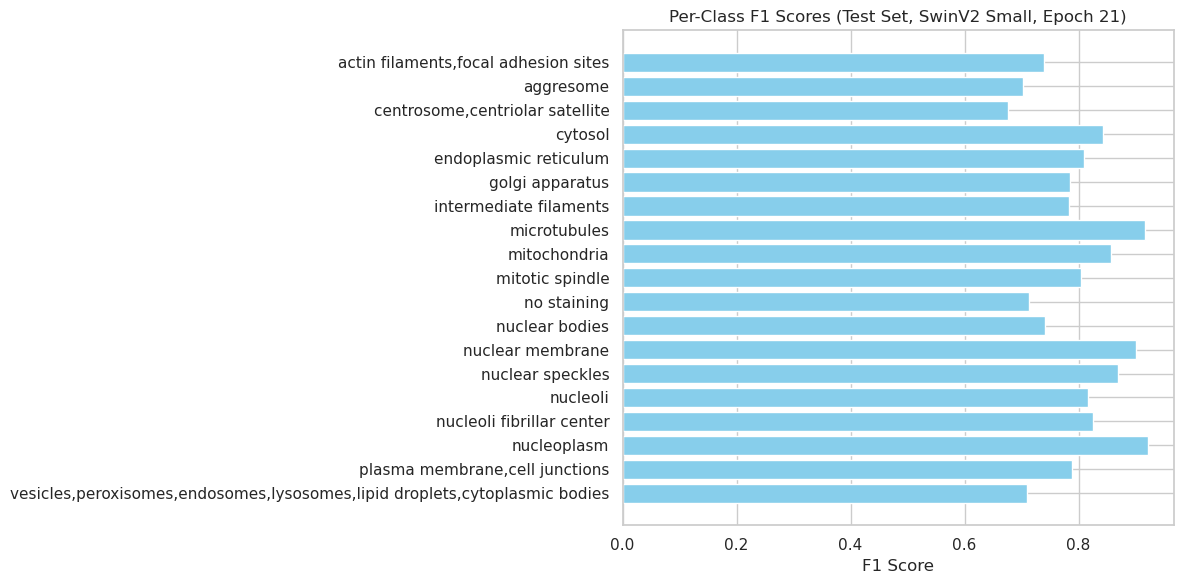

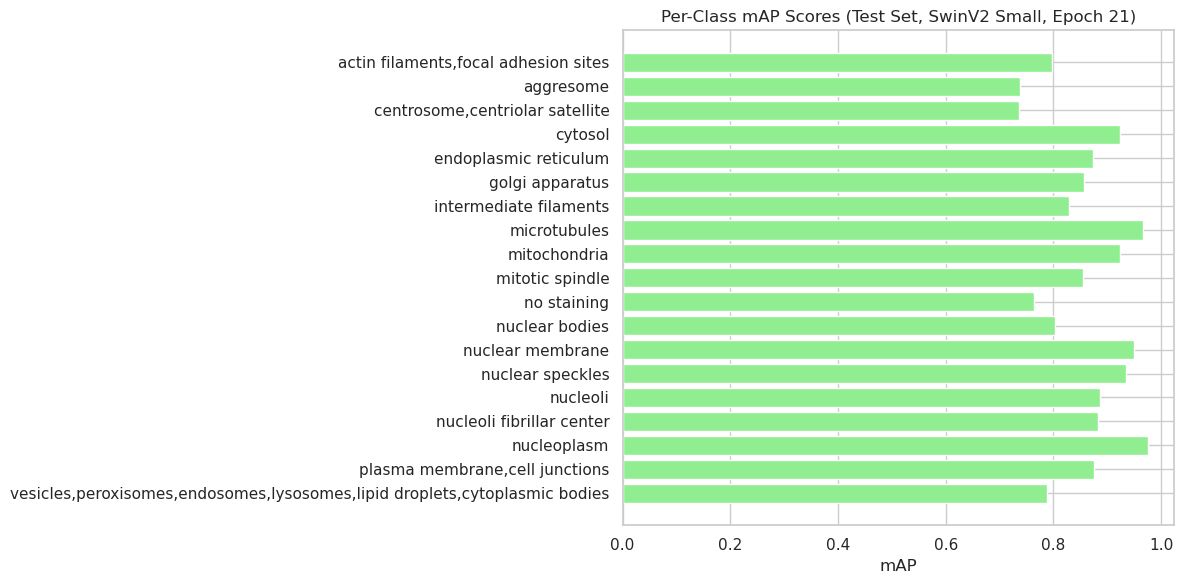

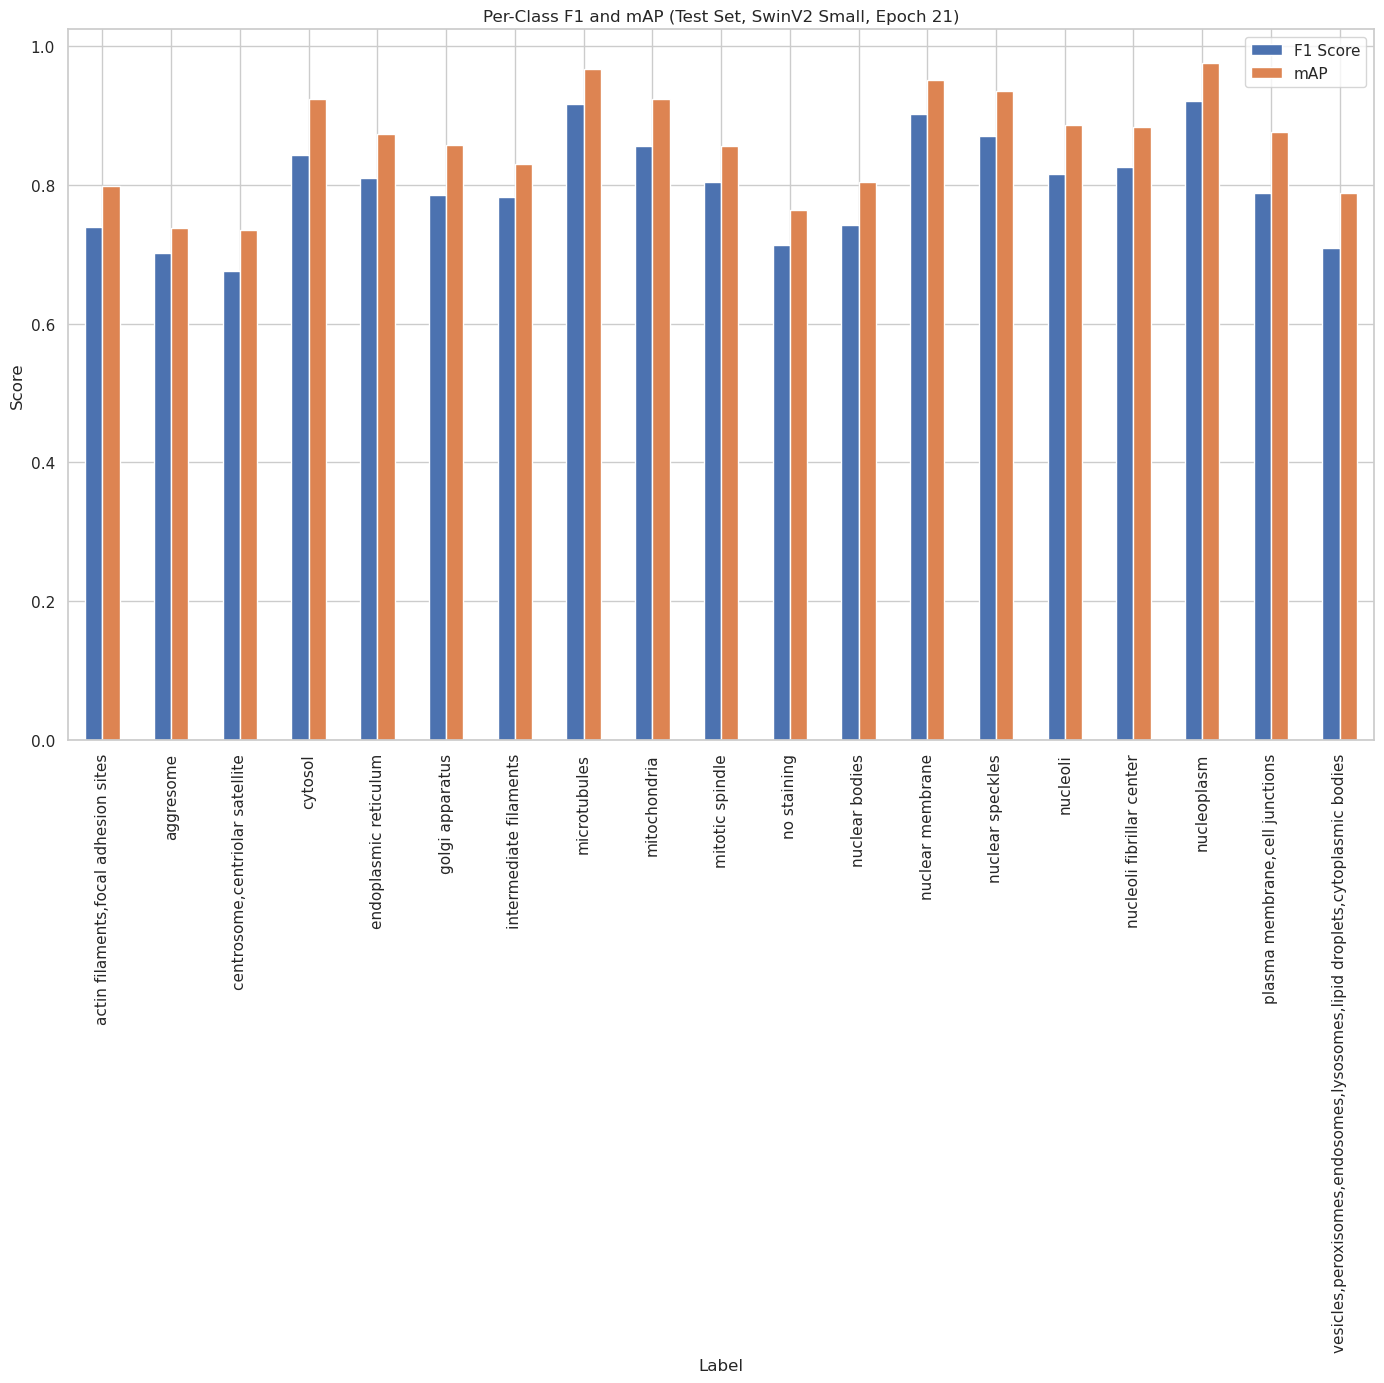

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV file
df = pd.read_csv("per_class_f1_map_test.csv")

# Check the structure
print(df.head())

# Plot F1 scores
plt.figure(figsize=(12, 6))
plt.barh(df['Label'], df['F1 Score'], color='skyblue')
plt.xlabel("F1 Score")
plt.title("Per-Class F1 Scores (Test Set, SwinV2 Small, Epoch 21)")
plt.gca().invert_yaxis()  # Highest on top
plt.tight_layout()
plt.show()

# Plot mAP scores
plt.figure(figsize=(12, 6))
plt.barh(df['Label'], df['mAP'], color='lightgreen')
plt.xlabel("mAP")
plt.title("Per-Class mAP Scores (Test Set, SwinV2 Small, Epoch 21)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Combined plot: F1 and mAP side by side
df.plot(x="Label", y=["F1 Score", "mAP"], kind="bar", figsize=(14, 14))
plt.title("Per-Class F1 and mAP (Test Set, SwinV2 Small, Epoch 21)")
plt.ylabel("Score")
plt.xticks(rotation=90)
plt.legend(["F1 Score", "mAP"])
plt.tight_layout()
plt.show()


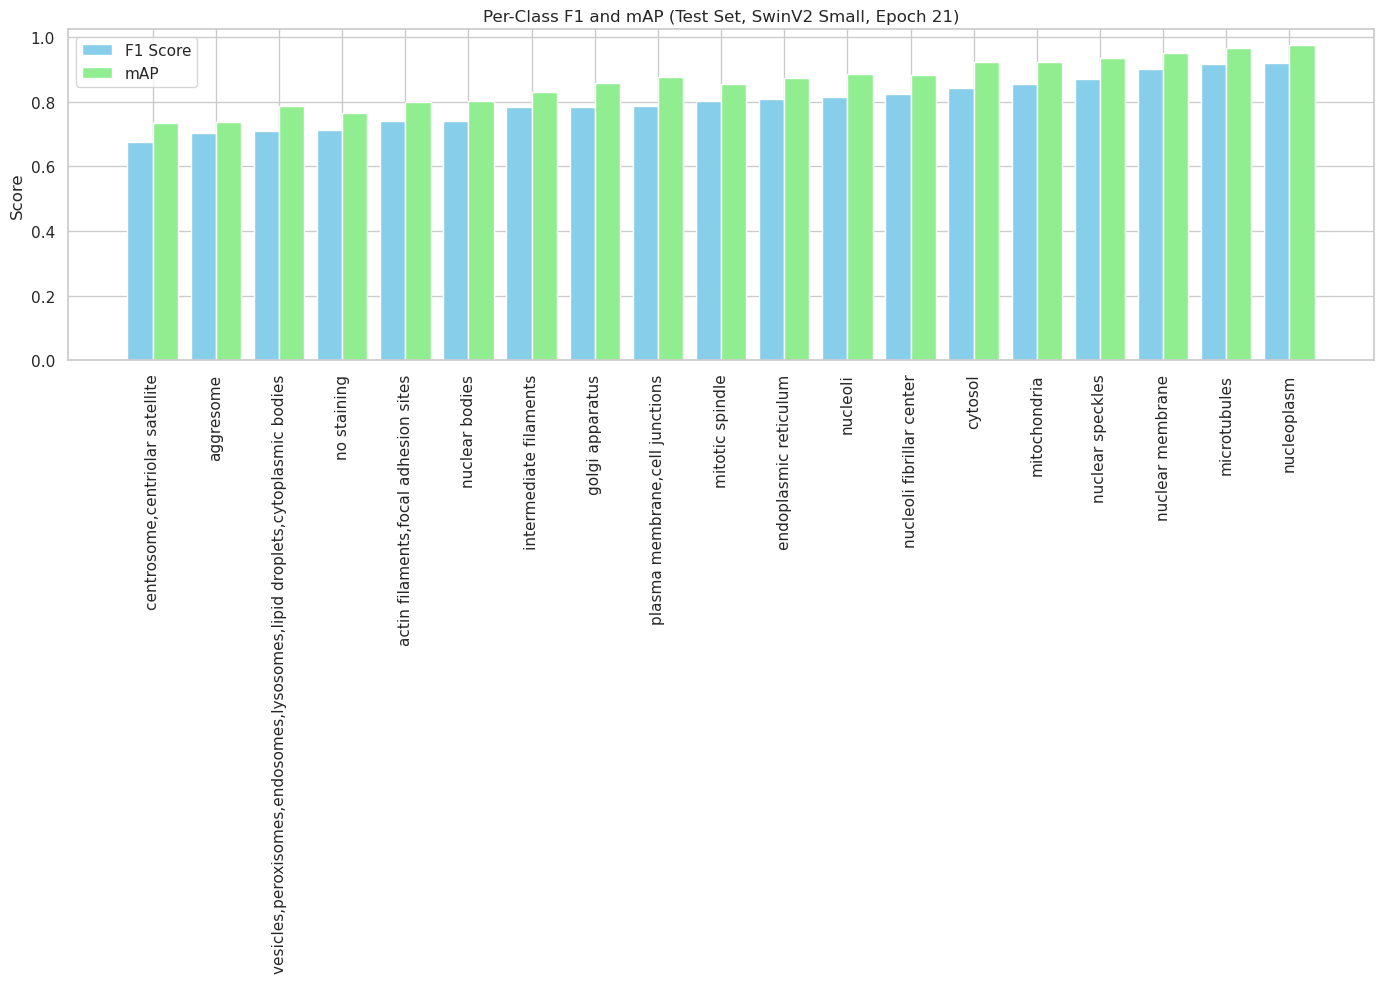

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV
df = pd.read_csv("per_class_f1_map_test.csv")

# Sort by F1 Score (ascending)
df_sorted = df.sort_values(by="F1 Score", ascending=True)

# Plot side-by-side bars
plt.figure(figsize=(14, 10))
bar_width = 0.4
x = range(len(df_sorted))

plt.bar([i - bar_width/2 for i in x], df_sorted["F1 Score"], 
        width=bar_width, label="F1 Score", color="skyblue")
plt.bar([i + bar_width/2 for i in x], df_sorted["mAP"], 
        width=bar_width, label="mAP", color="lightgreen")

# Formatting
plt.xticks(x, df_sorted["Label"], rotation=90)
plt.ylabel("Score")
plt.title("Per-Class F1 and mAP (Test Set, SwinV2 Small, Epoch 21)")
plt.legend()
plt.tight_layout()
plt.savefig("per_class_f1_map_test.png", dpi=300, bbox_inches="tight")  # 300 dpi for sharpness
plt.show()
